Googlenet on Freiburg Dataset

In [ ]:
import torch
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torch.utils.data as td
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
from matplotlib import image
from matplotlib import pyplot
import time
import torch.optim as optim

In [ ]:
def load_data(path, test_split, val_split, batch_size, input_size):
    
    transform_dict={'src':transforms.Compose([transforms.RandomHorizontalFlip(),transforms.ToTensor(),transforms.Normalize(mean=[0.5,0.5,0.5], std=[0.5,0.5,0.5])])}
    data1 = datasets.ImageFolder(root=path,transform=transform_dict['src'])
    test_size=int(len(data1)*test_split)
    val_size=int(len(data1)*val_split)
    train_size=len(data1)-val_size-test_size
    train_dataset,test_dataset,val_dataset=td.random_split(data1,[train_size,test_size,val_size])
    data_loader_train=td.DataLoader(train_dataset,batch_size,shuffle=True,drop_last=False,num_workers=0)
    data_loader_test=td.DataLoader(test_dataset,batch_size,shuffle=True,drop_last=False,num_workers=0)
    data_loader_val=td.DataLoader(val_dataset,batch_size,shuffle=True,drop_last=False,num_workers=0)  
    return data_loader_train, data_loader_test, data_loader_val

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
train_loader,test_loader,val_loader=load_data(path=r'/content/drive/MyDrive/Project/Dataset/Freiburg_dataset', 
                                          test_split=0.2,val_split= 0.2,batch_size=32, input_size=[256,256])

In [ ]:
def plot_data_loader(data_loader, gridDims):
    
    fig, axes = plt.subplots(nrows=gridDims[0], ncols=gridDims[1], figsize=(5,5))
    dataiter = iter(data_loader)
    for i in range(gridDims[0]):
        for j in range(gridDims[1]):
            images, _ = dataiter.next()
            axes[i, j].imshow(np.transpose(images[0].numpy(), (1, 2, 0)))

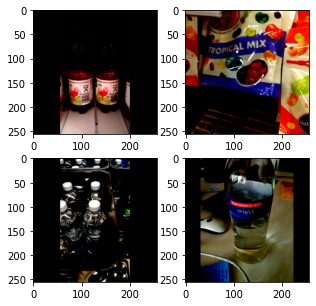

In [ ]:
plot_data_loader(train_loader,(2,2))

In [ ]:
model = torch.hub.load('pytorch/vision:v0.10.0', 'googlenet')
optimizer = torch.optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss()

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


In [ ]:
def train( model, train_loader,val_loader, criterion, optimizer,num_epochs):
      device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
      print("Device: {}".format(device))
      model.to(device)
      model.aux_logits=False
      total_steps = len(train_loader)
      t1 = time.time()
      accuracy1 = []
      loss1 = []
      val_acc=[]
      val_loss=[]
      for epoch in range(num_epochs):
          accu = 0
          lss = 0
          val_accu=0
          valid_loss=0
          for i,data in enumerate(train_loader):
              images, labels = data[0].to(device), data[1].to(device)
              # Forward pass
              outputs = model(images)
              loss = criterion(outputs, labels)
              # Backprop and optimisation
              optimizer.zero_grad()
              loss.backward()
              optimizer.step()
              # Train accuracy
              total = labels.size(0)
              _,predicted = torch.max(outputs.data, 1)
              correct = (predicted == labels).sum().item()
              accu += (correct / total) * 100
              lss += loss.item()
          accuracy1.append(accu/len(train_loader))
          loss1.append(lss/len(train_loader))
          model.eval()  
          for i, data in enumerate(val_loader):
              val_images, val_labels = data[0].to(device), data[1].to(device)
              outputs = model(val_images)
              loss = criterion(outputs, val_labels)
              # Val accuracy
              total = val_labels.size(0)
              _,predicted = torch.max(outputs.data, 1)
              correct = (predicted == val_labels).sum().item()
              val_accu += (correct / total) * 100
              valid_loss += loss.item()
          val_acc.append(val_accu/len(val_loader))
          val_loss.append(valid_loss/len(val_loader))
          
          
          print('Epoch [{}/{}], Loss: {:.4f}, Accuracy: {:.2f}%, Validation Loss : {:.4f}, Validation Accuracy : {:.2f}%,'.format(epoch + 1, num_epochs,lss/len(train_loader) ,accu/len(train_loader), valid_loss/len(val_loader), val_accu/len(val_loader)))
      print("######## Training Finished in {} seconds ###########".format(time.time()-t1))
      return model, accuracy1, loss1,val_acc,val_loss

In [ ]:
model1,accuracy1,loss1,val_acc1,val_loss1=train( model, train_loader,val_loader, criterion, optimizer,num_epochs=50)

Device: cuda:0
Epoch [1/50], Loss: 3.2020, Accuracy: 11.41%, Validation Loss : 4.1322, Validation Accuracy : 11.33%,
Epoch [2/50], Loss: 3.2617, Accuracy: 7.77%, Validation Loss : 3.1036, Validation Accuracy : 9.31%,
Epoch [3/50], Loss: 3.0835, Accuracy: 10.66%, Validation Loss : 3.1203, Validation Accuracy : 9.81%,
Epoch [4/50], Loss: 3.0533, Accuracy: 11.82%, Validation Loss : 3.0596, Validation Accuracy : 12.01%,
Epoch [5/50], Loss: 2.9974, Accuracy: 13.57%, Validation Loss : 2.9962, Validation Accuracy : 11.64%,
Epoch [6/50], Loss: 2.9719, Accuracy: 13.52%, Validation Loss : 2.9532, Validation Accuracy : 14.39%,
Epoch [7/50], Loss: 2.9377, Accuracy: 14.52%, Validation Loss : 2.9639, Validation Accuracy : 13.04%,
Epoch [8/50], Loss: 2.9290, Accuracy: 14.58%, Validation Loss : 3.0276, Validation Accuracy : 12.24%,
Epoch [9/50], Loss: 2.8992, Accuracy: 15.57%, Validation Loss : 2.8930, Validation Accuracy : 14.15%,
Epoch [10/50], Loss: 2.8819, Accuracy: 15.42%, Validation Loss : 2.885

In [ ]:
model1.eval() 
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model1 = model1.to(device)
with torch.no_grad(): 
    correct = 0
    total = 0
    for data in test_loader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = model1(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    print('Test Accuracy of the model on the {} test images: {} %'
        .format(total, (correct / total) * 100))

Test Accuracy of the model on the 989 test images: 31.749241658240646 %


In [ ]:
torch.save(model1, 'model_googlenet1.pt')
#model = torch.load('model_googlenet1.pt')
#model.eval()

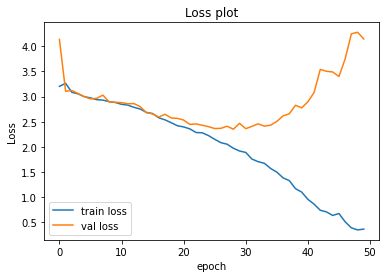

In [ ]:
import matplotlib.pyplot as plt

plt.figure()
plt.xlabel('epoch')
plt.ylabel('Loss')
plt.title('Loss plot')
plt.plot(loss1,label='train loss')
plt.plot(val_loss1,label='val loss')
    
plt.legend()


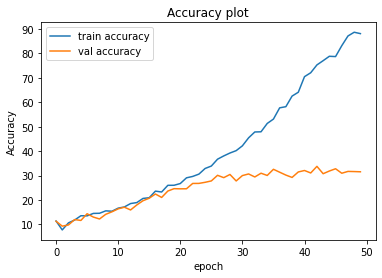

In [ ]:
import matplotlib.pyplot as plt

plt.figure()
plt.xlabel('epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy plot')
plt.plot(accuracy1,label='train accuracy')
plt.plot(val_acc1,label='val accuracy')    
plt.legend()

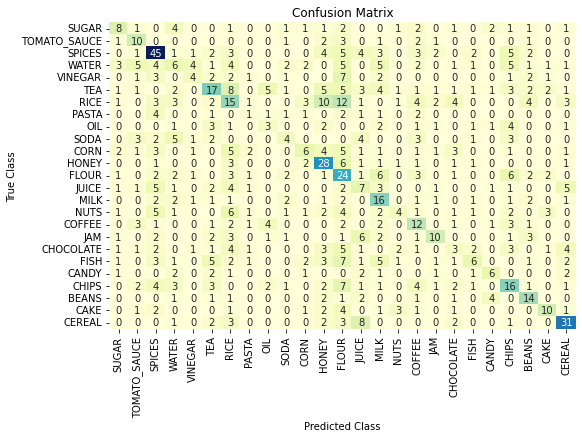

In [ ]:
#confusion Matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
import pandas as pd
y_true = []
y_pred = []
 
for data in test_loader:
  images,labels=data[0].to(device),data[1]
  y_true.extend(labels.numpy())
  outputs=model1(images)
  _, predicted = torch.max(outputs, 1)
  y_pred.extend(predicted.cpu().numpy())

cf_matrix = confusion_matrix(y_true, y_pred)
class_names = ('SUGAR', 'TOMATO_SAUCE', 'SPICES', 'WATER',
           'VINEGAR', 'TEA', 'RICE', 'PASTA', 'OIL', 'SODA','CORN','HONEY','FLOUR','JUICE','MILK','NUTS','COFFEE','JAM','CHOCOLATE','FISH','CANDY','CHIPS','BEANS','CAKE','CEREAL')
 
# Create pandas dataframe
dataframe = pd.DataFrame(cf_matrix, index=class_names, columns=class_names)

plt.figure(figsize=(8, 6))
 
# Create heatmap
sns.heatmap(dataframe, annot=True, cbar=None,cmap="YlGnBu",fmt="d")
 
plt.title("Confusion Matrix"), plt.tight_layout()
 
plt.ylabel("True Class"), 
plt.xlabel("Predicted Class")
plt.show()

In [ ]:
#classification Report
from sklearn.metrics import classification_report
print(classification_report(y_true, y_pred, target_names=class_names))

              precision    recall  f1-score   support

       SUGAR       0.35      0.29      0.31        28
TOMATO_SAUCE       0.32      0.45      0.38        22
      SPICES       0.48      0.54      0.51        83
       WATER       0.17      0.11      0.13        53
     VINEGAR       0.29      0.15      0.20        27
         TEA       0.34      0.26      0.29        66
        RICE       0.21      0.22      0.21        69
       PASTA       0.09      0.07      0.08        15
         OIL       0.19      0.14      0.16        21
        SODA       0.22      0.14      0.17        28
        CORN       0.30      0.16      0.21        38
       HONEY       0.38      0.60      0.46        47
       FLOUR       0.21      0.41      0.28        58
       JUICE       0.16      0.20      0.18        35
        MILK       0.27      0.46      0.34        35
        NUTS       0.29      0.11      0.16        36
      COFFEE       0.26      0.35      0.30        34
         JAM       0.43    

Transfer Learning on Freiburg Dataset with Googlenet pretrained weights

In [ ]:
model = torch.hub.load('pytorch/vision:v0.10.0', 'googlenet',pretrained=True)
optimizer = torch.optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss()

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


In [ ]:
model,accuracy1,loss1, val_acc1, val_loss1=train( model, train_loader,val_loader, criterion, optimizer,num_epochs=50)

Device: cuda:0
Epoch [1/50], Loss: 1.9217, Accuracy: 50.35%, Validation Loss : 1.3438, Validation Accuracy : 61.28%,
Epoch [2/50], Loss: 3.2495, Accuracy: 8.88%, Validation Loss : 3.2543, Validation Accuracy : 5.46%,
Epoch [3/50], Loss: 3.2183, Accuracy: 6.24%, Validation Loss : 3.2030, Validation Accuracy : 7.89%,
Epoch [4/50], Loss: 3.1880, Accuracy: 6.92%, Validation Loss : 3.1785, Validation Accuracy : 6.17%,
Epoch [5/50], Loss: 3.1806, Accuracy: 7.22%, Validation Loss : 3.2020, Validation Accuracy : 5.76%,
Epoch [6/50], Loss: 3.1884, Accuracy: 7.28%, Validation Loss : 3.2328, Validation Accuracy : 5.47%,
Epoch [7/50], Loss: 3.1840, Accuracy: 7.22%, Validation Loss : 3.2042, Validation Accuracy : 7.87%,
Epoch [8/50], Loss: 3.1834, Accuracy: 5.72%, Validation Loss : 3.2232, Validation Accuracy : 4.85%,
Epoch [9/50], Loss: 3.1854, Accuracy: 6.62%, Validation Loss : 3.1782, Validation Accuracy : 5.49%,
Epoch [10/50], Loss: 3.1818, Accuracy: 5.92%, Validation Loss : 3.1814, Validation 

KeyboardInterrupt: ignored

In [ ]:
import matplotlib.pyplot as plt

num_epochs= 50
plt.figure()
plt.xlabel('epoch')
plt.ylabel('Loss')
plt.title('Loss plot')
epochs = [i for i in range(num_epochs)]

plt.plot(loss1,label='train loss')
plt.plot(val_loss1,label='val loss')
    
plt.legend()

In [ ]:
import matplotlib.pyplot as plt

num_epochs= 50
plt.figure()
plt.xlabel('epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy plot')
plt.plot(accuracy1,label='train accuracy')
plt.plot(val_acc1,label='val accuracy')    
plt.legend()

In [ ]:
model.eval() 
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
with torch.no_grad(): 
    correct = 0
    total = 0
    for data in test_loader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    print('Test Accuracy of the model on the {} test images: {} %'
        .format(total, (correct / total) * 100))

In [ ]:
torch.save(model, 'model_googlenet1_transfer.pt')

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
y_true = []
y_pred = []
 
for data in test_loader:
  images,labels=data[0].to(device),data[1]
  y_true.extend(labels.numpy())
  outputs=model(images)
  _, predicted = torch.max(outputs, 1)
  y_pred.extend(predicted.cpu().numpy())

cf_matrix = confusion_matrix(y_true, y_pred)
class_names = ('SUGAR', 'TOMATO_SAUCE', 'SPICES', 'WATER',
           'VINEGAR', 'TEA', 'RICE', 'PASTA', 'OIL', 'SODA','CORN','HONEY','FLOUR','JUICE','MILK','NUTS','COFFEE','JAM','CHOCOLATE','FISH','CANDY','CHIPS','BEANS','CAKE','CEREAL')
 
# Create pandas dataframe
dataframe = pd.DataFrame(cf_matrix, index=class_names, columns=class_names)

plt.figure(figsize=(8, 6))
 
# Create heatmap
sns.heatmap(dataframe, annot=True, cbar=None,cmap="YlGnBu",fmt="d")
 
plt.title("Confusion Matrix"), plt.tight_layout()
 
plt.ylabel("True Class"), 
plt.xlabel("Predicted Class")
plt.show()

In [ ]:
#Classification Report
from sklearn.metrics import classification_report
print(classification_report(y_true, y_pred, target_names=class_names))

Googlenet on Grocery Dataset

In [ ]:
import torch
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torch.utils.data as td
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
from matplotlib import image
from matplotlib import pyplot
import time
import torch.optim as optim

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
def load_data_grocery_store(path, batch_size, input_size):
    
    transform_dict={'src':transforms.Compose([transforms.CenterCrop(224), transforms.RandomRotation(5), transforms.RandomHorizontalFlip(),
                                              transforms.ToTensor(),transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])}
    data1 = datasets.ImageFolder(root=path,transform=transform_dict['src'])
    data_loader=td.DataLoader(data1,batch_size,shuffle=True,drop_last=False,num_workers=0)  
    return data_loader

train_loader2=load_data_grocery_store(path=r'/content/drive/MyDrive/Project/Dataset/Grocery_store_dataset/Train', batch_size=32, input_size=[224,224])
test_loader2=load_data_grocery_store(path=r'/content/drive/MyDrive/Project/Dataset/Grocery_store_dataset/Test', batch_size=32, input_size=[224,224])
val_loader2=load_data_grocery_store(path=r'/content/drive/MyDrive/Project/Dataset/Grocery_store_dataset/Val', batch_size=32, input_size=[224,224])

In [ ]:
plot_data_loader(train_loader2,(2,2))

In [ ]:
model2 = torch.hub.load('pytorch/vision:v0.10.0', 'googlenet')
optimizer2 = torch.optim.Adam(model2.parameters())
criterion2 = nn.CrossEntropyLoss()

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


In [ ]:
def train( model, train_loader,val_loader, criterion, optimizer,num_epochs):
      device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
      print("Device: {}".format(device))
      model.to(device)
      model.aux_logits=False
      total_steps = len(train_loader)
      t1 = time.time()
      accuracy1 = []
      loss1 = []
      val_acc=[]
      val_loss=[]
      for epoch in range(num_epochs):
          accu = 0
          lss = 0
          val_accu=0
          valid_loss=0
          for i,data in enumerate(train_loader):
              images, labels = data[0].to(device), data[1].to(device)
              # Forward pass
              outputs = model(images)
              loss = criterion(outputs, labels)
              # Backprop and optimisation
              optimizer.zero_grad()
              loss.backward()
              optimizer.step()
              # Train accuracy
              total = labels.size(0)
              _,predicted = torch.max(outputs.data, 1)
              correct = (predicted == labels).sum().item()
              accu += (correct / total) * 100
              lss += loss.item()
          model.eval()  
          for i, data in enumerate(val_loader):
              val_images, val_labels = data[0].to(device), data[1].to(device)
              outputs = model(val_images)
              loss = criterion(outputs, val_labels)
              # Val accuracy
              total = val_labels.size(0)
              _,predicted = torch.max(outputs.data, 1)
              correct = (predicted == val_labels).sum().item()
              val_accu += (correct / total) * 100
              valid_loss += loss.item()
          val_acc.append(val_accu/len(val_loader))
          val_loss.append(valid_loss/len(val_loader))
          accuracy1.append(accu/len(train_loader))
          loss1.append(lss/len(train_loader))
          
          print('Epoch [{}/{}], Loss: {:.4f}, Accuracy: {:.2f}%, Validation Loss : {:.4f}, Validation Accuracy : {:.2f}%,'.format(epoch + 1, num_epochs,lss/len(train_loader) ,accu/len(train_loader), valid_loss/len(val_loader), val_accu/len(val_loader)))
      print("######## Training Finished in {} seconds ###########".format(time.time()-t1))
      return model, accuracy1, loss1,val_acc,val_loss

In [ ]:
model2,accuracy2,loss2,val_acc2,val_loss2=train(model2, train_loader2,val_loader2, criterion2, optimizer2,num_epochs=50)

Device: cuda:0
Epoch [1/50], Loss: 2.9895, Accuracy: 18.97%, Validation Loss : 3.3650, Validation Accuracy : 13.35%,
Epoch [2/50], Loss: 2.9932, Accuracy: 15.44%, Validation Loss : 2.7839, Validation Accuracy : 14.12%,
Epoch [3/50], Loss: 2.6658, Accuracy: 20.83%, Validation Loss : 2.7390, Validation Accuracy : 11.59%,
Epoch [4/50], Loss: 2.4240, Accuracy: 23.70%, Validation Loss : 2.6008, Validation Accuracy : 18.29%,
Epoch [5/50], Loss: 2.1916, Accuracy: 28.16%, Validation Loss : 2.4022, Validation Accuracy : 21.25%,
Epoch [6/50], Loss: 1.9917, Accuracy: 33.43%, Validation Loss : 2.4342, Validation Accuracy : 20.78%,
Epoch [7/50], Loss: 1.9341, Accuracy: 35.22%, Validation Loss : 2.1191, Validation Accuracy : 26.61%,
Epoch [8/50], Loss: 1.7959, Accuracy: 38.85%, Validation Loss : 2.2491, Validation Accuracy : 25.70%,
Epoch [9/50], Loss: 1.7133, Accuracy: 41.99%, Validation Loss : 2.0764, Validation Accuracy : 28.68%,
Epoch [10/50], Loss: 1.6161, Accuracy: 44.88%, Validation Loss : 1.

In [ ]:
model2.eval() 
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model2 = model2.to(device)
with torch.no_grad(): 
    correct = 0
    total = 0
    for data in test_loader2:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = model2(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    print('Test Accuracy of the model on the {} test images: {} %'
        .format(total, (correct / total) * 100))

[1.4030278427036185, 3.228152135485097, 2.179536422616557, 1.6562528014183044, 1.1124927589767857, 0.9087635498297842, 0.5961370199526611, 0.6028931936935374, 0.4833240780587259, 0.5147232030959505, 0.3311333125947337, 0.37348188626530926, 0.2646281807438323, 0.2696243628467384, 0.28678885957618294, 0.14372990547532313, 0.2585854678365745, 0.12131534556024953, 0.21002292696778713, 0.20610764995217323, 0.2189514295835244, 0.17720600167338393, 0.23995535728203035, 0.19406641152148185, 0.15248837643057891, 0.14003729183030755, 0.08968408343284145, 0.17968951324368582, 0.031304099481770355, 0.1671643849641489, 0.14611316610764907, 0.23973283759857478, 0.19418481727571865, 0.09692428303012428, 0.11678615171235594, 0.01807564173903206, 0.012790569021538096, 0.013425467575488207, 0.15574193106716083, 0.1526101771068122, 0.18599683304905498, 0.14461679498689542, 0.13005956990558556, 0.11335960872728672, 0.01409572316295357, 0.001262606242993283, 0.0005271185509388344, 0.00032017699446011027, 0

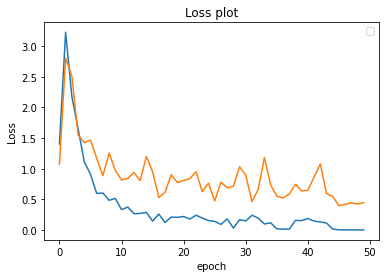

In [ ]:
import matplotlib.pyplot as plt

plt.figure()
plt.xlabel('epoch')
plt.ylabel('Loss')
plt.title('Loss plot')
plt.plot(loss2,label='Train Loss')
plt.plot(val_loss2,lable='Validation Loss')
plt.legend()

print(loss2)

[66.87987329434698, 14.897051656920077, 29.819992690058477, 43.99061890838207, 61.81164717348928, 69.4474902534113, 80.3149366471735, 80.15046296296296, 84.32931286549707, 83.48866959064327, 88.47161306042885, 88.3406432748538, 91.49153265107213, 91.5402655945419, 91.67884990253411, 95.05056042884989, 91.73824317738791, 96.44858674463937, 93.55506822612085, 93.11038011695906, 93.20784600389864, 94.9759381091618, 93.33120126705653, 93.90685916179338, 95.33838937621832, 95.64144736842105, 96.86738547758284, 94.31042884990252, 99.09539473684211, 95.47240497076022, 95.8470394736842, 93.54440789473684, 93.82462231968812, 97.16282894736842, 96.95723684210526, 99.50657894736842, 99.62231968810916, 99.62993421052632, 95.77546296296296, 95.01705653021443, 94.03021442495127, 95.30488547758284, 96.33284600389864, 96.4150828460039, 99.71217105263158, 100.0, 100.0, 100.0, 100.0, 100.0]


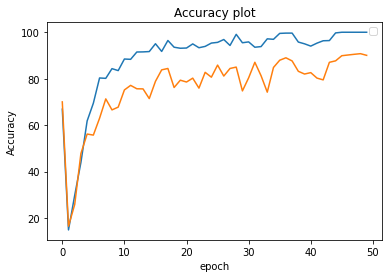

In [ ]:
import matplotlib.pyplot as plt

plt.figure()
plt.xlabel('epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy plot')
plt.plot(accuracy2,label='Train Accuracy')
plt.plot(val_acc2,label='Validation Accuracy')  
plt.legend()

print(accuracy2)

In [ ]:
torch.save(model2, 'model_googlenet2.pt')

In [ ]:
#confusion matrix
from sklearn.metrics import confusion_matrix
import pandas as pd
import seaborn as sns
y_true = []
y_pred = []
 
for data in test_loader2:
  images,labels=data[0].to(device),data[1]
  y_true.extend(labels.numpy())
  outputs=model2(images)
  _, predicted = torch.max(outputs, 1)
  y_pred.extend(predicted.cpu().numpy())

cf_matrix = confusion_matrix(y_true, y_pred)
class_names = ('SUGAR', 'TOMATO_SAUCE', 'SPICES', 'WATER',
           'VINEGAR', 'TEA', 'RICE', 'PASTA', 'OIL', 'SODA','CORN','HONEY','FLOUR','JUICE','MILK','NUTS','COFFEE','JAM','CHOCOLATE','FISH','CANDY','CHIPS','BEANS','CAKE','CEREAL')
# Create pandas dataframe
dataframe = pd.DataFrame(cf_matrix, index=class_names, columns=class_names)

plt.figure(figsize=(8, 6))
 
# Create heatmap
sns.heatmap(dataframe, annot=True, cbar=None,cmap="YlGnBu",fmt="d")
 
plt.title("Confusion Matrix"), plt.tight_layout()
 
plt.ylabel("True Class"), 
plt.xlabel("Predicted Class")
plt.show()

In [ ]:
#Classification Report
from sklearn.metrics import classification_report
print(classification_report(y_true, y_pred, target_names=class_names))